<a href="https://colab.research.google.com/github/yinhao0424/CS539/blob/master/pytorch_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(8)

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path='/content/drive/My Drive/all_data.npy'
images=np.load(path)
new_images=images/255

In [0]:
label_path='/content/drive/My Drive/gray_label.npy'
labels=np.load(label_path)
mean=np.mean(labels)
std=np.std(labels)
labels.shape

(28859,)

In [0]:
threshhold_up=mean+2*std
threshhold_down=mean-2*std
labels_c5=labels.copy()
labels_c5[labels>=threshhold_up]=2
labels_c5[(labels<threshhold_up) & (labels>threshhold_down)]=1
labels_c5[labels<threshhold_down]=0
# np.unique(labels_c5, return_counts=True)


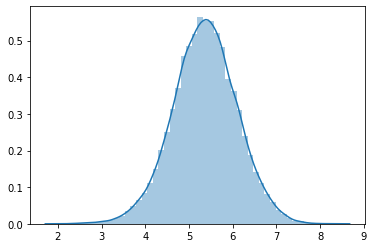

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
ax=sns.distplot(labels)


fig = ax.get_figure()

fig.savefig("gaussian_dis.png")

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(new_images, labels_c5, test_size=0.05)
X_train, X_test, y_train, y_test = train_test_split(new_images, labels_c5, test_size=0.1)

In [0]:
def convert2tensor(X,Y,batch_size):
    from torch.utils import data
    X_new=np.asarray(X)
    X_new_trans=np.transpose(X_new, (0,3, 1,2))
    target = np.asarray(Y)
    tensor_data = torch.from_numpy(X_new_trans)
    tensor_data = tensor_data.float()
    tensor_target = torch.from_numpy(target)
    loader = data.TensorDataset(tensor_data, tensor_target)
    loader_dataset = data.DataLoader(loader, batch_size=batch_size, shuffle=True)
    return loader_dataset

train_loader=convert2tensor(X_train,y_train,16)
test_loader=convert2tensor(X_test,y_test,16)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(64 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [0]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
#         self.fc1 = nn.Linear(32 * 32 * 32, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 3)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 32 * 32 * 32)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

net = Net()
# net = SimpleNet(num_classes=3)

net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_accuracy=[]

n_e=150
for epoch in range(n_e):  # loop over the dataset multiple times
    correct=0
    iterations=0
    iter_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        labels_c= torch.tensor(labels, dtype=torch.long,device=device)
        loss = criterion(outputs, labels_c).to(device)
        loss.backward()
        optimizer.step()
        iterations+=1
        # print statistics
        iter_loss += loss.item()
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        train_accuracy.append((100 * correct / X_train.shape[0]))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images).to(device)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 1000 test images: %d %%' % (100*correct/total))
    print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}'.format(epoch+1, n_e,iter_loss/iterations,train_accuracy[-1]))            
print('Finished Training')


PATH = './three_class_1.pth'


In [0]:
classes = (0,1,2)
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
pred_list=[]
y_true=[]
with torch.no_grad():  
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = net(images).to(device)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        pred_list.append(predicted)
        y_true.append(labels)
        
        for i in range(len(labels)):
            label = labels[i]
            label_int=torch.tensor(label,dtype=torch.int16)
            class_correct[label_int] += c[i].item()
            class_total[label_int] += 1
        


for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of     0 :  0 %
Accuracy of     1 : 99 %
Accuracy of     2 :  0 %


In [0]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)


[228.0, 989.0, 226.0]

In [0]:
y_t=torch.cat(y_true,dim=0)
y_p=torch.cat(pred_list,dim=0)
y_t_n=y_t.cpu().numpy()
y_p_n=y_p.cpu().numpy()


In [0]:
import sklearn.metrics as metrics
metrics.confusion_matrix(y_t_n, y_p_n,labels=[0,1,2])

array([[  0, 232,   0],
       [  0, 993,   1],
       [  0, 217,   0]])